<a href="https://colab.research.google.com/github/mHasNain084/Railway-management-system/blob/main/Stocks_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, InputLayer, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [147]:
# IMPORTING THE DATA OF A COMAPNY FROM YAHOO FINANCE

# Create a Ticker object
apple = yf.Ticker("AAPL")

# Get full available history from earliest date to today
data = apple.history(period="max")  # Use period="max" to get all available data
data.reset_index(inplace=True)
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1980-12-12 00:00:00-05:00,0.098597,0.099025,0.098597,0.098597,469033600,0.0,0.0
1,1980-12-15 00:00:00-05:00,0.093881,0.093881,0.093453,0.093453,175884800,0.0,0.0
2,1980-12-16 00:00:00-05:00,0.087022,0.087022,0.086594,0.086594,105728000,0.0,0.0
3,1980-12-17 00:00:00-05:00,0.088737,0.089165,0.088737,0.088737,86441600,0.0,0.0
4,1980-12-18 00:00:00-05:00,0.091310,0.091738,0.091310,0.091310,73449600,0.0,0.0


In [148]:
data.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
11245,2025-07-28 00:00:00-04:00,214.029999,214.850006,213.059998,214.050003,37858000,0.0,0.0
11246,2025-07-29 00:00:00-04:00,214.179993,214.809998,210.820007,211.270004,51411700,0.0,0.0
11247,2025-07-30 00:00:00-04:00,211.899994,212.389999,207.720001,209.050003,45512500,0.0,0.0
11248,2025-07-31 00:00:00-04:00,208.490005,209.839996,207.160004,207.570007,80698400,0.0,0.0
11249,2025-08-01 00:00:00-04:00,210.869995,213.580002,201.500000,202.380005,104301700,0.0,0.0


In [149]:
data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,11250.000000,11250.000000,11250.000000,11250.000000,1.125000e+04,11250.000000,11250.000000
mean,25.880976,26.163591,25.614262,25.900965,3.121527e+08,0.000825,0.001511
std,53.777281,54.363920,53.236826,53.828433,3.340030e+08,0.012553,0.082721
min,0.038153,0.038153,0.037724,0.037724,0.000000e+00,0.000000,0.000000
25%,0.244572,0.250295,0.239494,0.244739,1.084566e+08,0.000000,0.000000
50%,0.461041,0.468090,0.454655,0.462622,2.007208e+08,0.000000,0.000000
75%,20.316744,20.417513,20.127580,20.292530,3.916731e+08,0.000000,0.000000
max,257.568678,259.474086,257.010028,258.396667,7.421641e+09,0.260000,7.000000


In [150]:
dataForProphet = pd.DataFrame(data[0:int(len(data)*0.9)])
test_data = pd.DataFrame(data[int(len(data)*0.9):int(len(data))])

dataForProphet.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
10120,2021-02-02 00:00:00-05:00,132.404845,132.970638,131.312288,131.682983,83305400,0.000,0.0
10121,2021-02-03 00:00:00-05:00,132.434097,132.443861,130.336774,130.658691,89880900,0.000,0.0
10122,2021-02-04 00:00:00-05:00,132.960892,134.033935,131.292777,134.024185,84183100,0.000,0.0
10123,2021-02-05 00:00:00-05:00,134.185426,134.253806,132.729751,133.609009,75693800,0.205,0.0
10124,2021-02-08 00:00:00-05:00,132.895795,133.804375,131.811369,133.755524,71297200,0.000,0.0


In [151]:
test_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
10125,2021-02-09 00:00:00-05:00,133.472197,134.703176,132.719949,132.876251,76774200,0.0,0.0
10126,2021-02-10 00:00:00-05:00,133.335405,133.833664,131.303328,132.270523,73046600,0.0,0.0
10127,2021-02-11 00:00:00-05:00,132.768819,133.247535,130.687905,132.016571,64280000,0.0,0.0
10128,2021-02-12 00:00:00-05:00,131.254504,132.407309,130.609707,132.250992,60145100,0.0,0.0
10129,2021-02-16 00:00:00-05:00,132.368287,132.876296,129.730484,130.121277,80576300,0.0,0.0


In [152]:
dataForProphet.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,10125.000000,10125.000000,10125.000000,10125.000000,1.012500e+04,10125.000000,10125.000000
mean,9.446239,9.548802,9.342059,9.449358,3.389757e+08,0.000520,0.001679
std,19.644278,19.877521,19.403174,19.650779,3.415597e+08,0.009024,0.087194
min,0.038153,0.038153,0.037724,0.037724,0.000000e+00,0.000000,0.000000
25%,0.225406,0.229773,0.220297,0.225406,1.303916e+08,0.000000,0.000000
50%,0.363055,0.370223,0.356040,0.362826,2.265088e+08,0.000000,0.000000
75%,9.887529,9.984900,9.770617,9.841543,4.218284e+08,0.000000,0.000000
max,140.082040,141.535523,137.906661,139.652817,7.421641e+09,0.205000,7.000000


In [153]:
test_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1125.000000,1125.000000,1125.000000,1125.000000,1.125000e+03,1125.000000,1125.0
mean,173.793614,175.696689,172.064089,173.965427,7.074580e+07,0.003573,0.0
std,33.713633,33.947832,33.488021,33.755320,2.942228e+07,0.028901,0.0
min,116.287507,117.625931,113.532471,113.679016,2.323470e+07,0.000000,0.0
25%,146.022886,147.487273,144.590292,146.137009,4.970930e+07,0.000000,0.0
50%,169.841456,171.661295,168.661039,170.102676,6.455610e+07,0.000000,0.0
75%,194.779081,197.699997,193.413605,195.973495,8.491430e+07,0.000000,0.0
max,257.568678,259.474086,257.010028,258.396667,3.186799e+08,0.260000,0.0


In [154]:
# CONVERTING THE TEST DATA (dataForProphet) INTO A NEW FORMAT ACCEPTED BY PROPHET

dataForProphet = dataForProphet[['Date', 'High']]
dataForProphet.columns = ['ds', 'y']
dataForProphet['ds'] = dataForProphet['ds'].dt.tz_localize(None)
dataForProphet.head()

/tmp/ipython-input-2983300102.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
0,1980-12-12,0.099025
1,1980-12-15,0.093881
2,1980-12-16,0.087022
3,1980-12-17,0.089165
4,1980-12-18,0.091738


In [155]:
# USING BUILT-IN PROPHET MODEL TO DETECT THE TREND IN THE STOCK PRICE OVER TIME

prophetModel = Prophet()
prophetModel.fit(dataForProphet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6d00zuq7/gl5eucag.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6d00zuq7/71qel4ng.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89709', 'data', 'file=/tmp/tmp6d00zuq7/gl5eucag.json', 'init=/tmp/tmp6d00zuq7/71qel4ng.json', 'output', 'file=/tmp/tmp6d00zuq7/prophet_modelmvdk7uw9/prophet_model-20250804115626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [156]:
# Predict the next 60 days
future = prophetModel.make_future_dataframe(periods=60, freq='D')

In [157]:
# Forecast
forecast = prophetModel.predict(future)
forecast = forecast[['ds', 'yhat']]
forecast = pd.DataFrame(forecast)
forecast.head()

,ds,yhat
0,1980-12-12,0.565554
1,1980-12-15,0.702679
2,1980-12-16,0.688251
3,1980-12-17,0.701317
4,1980-12-18,0.708983


In [158]:
forecast.describe()

,ds,yhat
count,10185,10185.000000
mean,2001-02-13 23:38:39.057437440,9.951206
min,1980-12-12 00:00:00,-0.852529
25%,1991-01-09 00:00:00,0.050079
50%,2001-02-06 00:00:00,0.846980
75%,2011-03-23 00:00:00,7.792988
max,2021-04-09 00:00:00,78.472580
std,NaN,19.317026


In [159]:
# Merge predicted and actual data
merged = pd.merge(forecast[['ds', 'yhat']], dataForProphet, on='ds', how='left')

In [160]:
# Compute error only where actual price is known

merged['error'] = merged['yhat'] - merged['y']
merged.head()

,ds,yhat,y,error
0,1980-12-12,0.565554,0.099025,0.466529
1,1980-12-15,0.702679,0.093881,0.608798
2,1980-12-16,0.688251,0.087022,0.601229
3,1980-12-17,0.701317,0.089165,0.612152
4,1980-12-18,0.708983,0.091738,0.617245


In [161]:
merged.describe()

,ds,yhat,y,error
count,10185,10185.000000,10125.000000,10125.000000
mean,2001-02-13 23:38:39.057437440,9.951206,9.548802,0.000015
min,1980-12-12 00:00:00,-0.852529,0.038153,-63.292028
25%,1991-01-09 00:00:00,0.050079,0.229773,-0.648113
50%,2001-02-06 00:00:00,0.846980,0.370223,0.182055
75%,2011-03-23 00:00:00,7.792988,9.984900,0.640177
max,2021-04-09 00:00:00,78.472580,141.535523,24.547223
std,NaN,19.317026,19.877521,6.765780


In [162]:
# Create interactive plot with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

In [163]:
# Plot predicted price
fig.add_trace(go.Scatter(
    x=merged['ds'], y=merged['yhat'], mode='lines',
    name='Predicted Price', line=dict(color='blue')
), secondary_y=False)

# Plot actual price
fig.add_trace(go.Scatter(
    x=merged['ds'], y=merged['y'], mode='lines',
    name='Actual Price', line=dict(color='green')
), secondary_y=False)

# Customize layout
fig.update_layout(
    title='📊 Actual vs Predicted Stock Price with Prediction Error (AAPL)',
    xaxis_title='Date',
    yaxis_title='Stock Price (USD)',
    height=650,
    legend=dict(x=0.01, y=0.99)
)

fig.show()

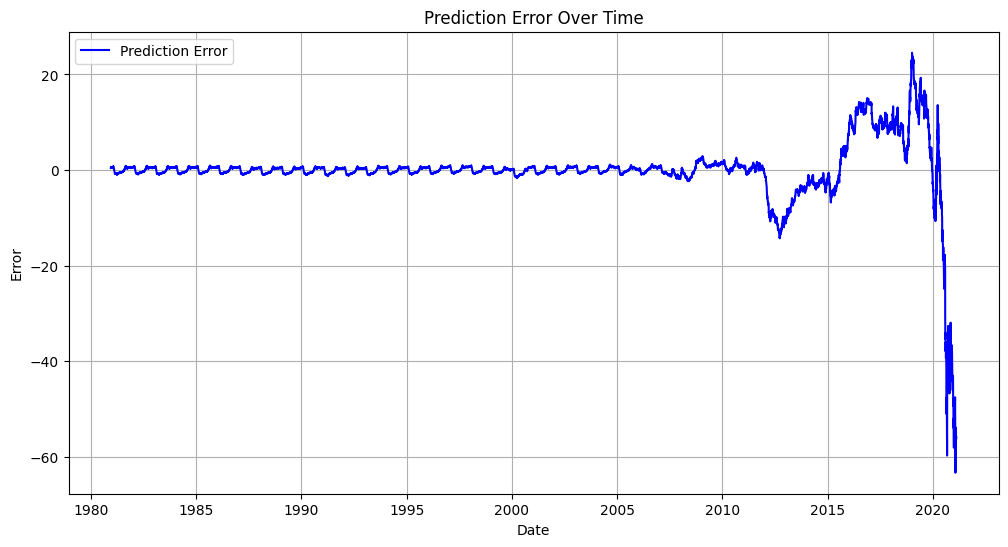

In [164]:
# plotting the error between predicted and actual value using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(merged['ds'], merged['error'], label='Prediction Error', color='blue')
plt.title('Prediction Error Over Time')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

In [165]:
# DROP LAST 60 ROWS OF MERGED DATASET BECAUSE yhat HAS 60 EXTRA ENTRIES
# FOR THE PREDICTION FROM PROPHET MODEL AGAINST THE NULL VALUES OF y

LSTM_data = merged[['error']].iloc[:-60]
LSTM_data.head()

,error
0,0.466529
1,0.608798
2,0.601229
3,0.612152
4,0.617245


In [166]:
LSTM_data.tail()

,error
10120,-54.831383
10121,-54.335614
10122,-55.964389
10123,-56.307442
10124,-55.902721


In [167]:
LSTM_data.describe()

,error
count,10125.000000
mean,0.000015
std,6.765780
min,-63.292028
25%,-0.648113
50%,0.182055
75%,0.640177
max,24.547223


In [168]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(LSTM_data)

In [169]:
scaled_data.shape

(10125, 1)

In [170]:
LSTM_train = pd.DataFrame(scaled_data[0:int(len(scaled_data)*0.9)], columns=['error'])
LSTM_test = pd.DataFrame(scaled_data[int(len(scaled_data)*0.9):], columns=['error'])

In [171]:
# Extract dates before scaling
dates = merged['ds'].iloc[:-60]  # drop last 60 rows as before

train_dates = dates[0:int(len(dates) * 0.9)]
test_dates = dates[int(len(dates) * 0.9):]

In [172]:
print(len(train_dates), len(LSTM_train))
print(len(test_dates), len(LSTM_test))

9112 9112
1013 1013


In [173]:
print(LSTM_train.shape, LSTM_test.shape)
print(LSTM_train.head())

(9112, 1) (1013, 1)
      error
0  0.725855
1  0.727475
2  0.727388
3  0.727513
4  0.727571


In [174]:
print(f"train_shape: {LSTM_train.shape}")
print(f"test_shape: {LSTM_test.shape}")

train_shape: (9112, 1)
test_shape: (1013, 1)


In [175]:
WINDOW_SIZE = 30

In [176]:
def data_to_input_and_output(data):
    input_data = []
    output_data = []

    errors = data['error'].values  # Extract as numpy array for consistency

    for index in range(0, len(errors) - WINDOW_SIZE):
        input_sample = errors[index:index + WINDOW_SIZE].reshape(WINDOW_SIZE, 1)  # (30, 1)
        output_sample = errors[index + WINDOW_SIZE]  # scalar

        input_data.append(input_sample)
        output_data.append(output_sample)

    return np.array(input_data), np.array(output_data)

In [177]:
train_input, train_output = data_to_input_and_output(LSTM_train)
test_input, test_output = data_to_input_and_output(LSTM_test)

In [178]:
def train_neural_network(X, y, epochs=7, learning_rate=0.005):

    model = Sequential()
    model.add(InputLayer((WINDOW_SIZE, 1)))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    check_point = ModelCheckpoint('model/.keras', save_best_only=True, monitor='loss')
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])

    model.fit(X, y, epochs=epochs, validation_split=0.1, callbacks=[check_point])
    return model

In [181]:
model = train_neural_network(train_input, train_output)

model = load_model('model/.keras')

Epoch 1/7
256/256 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0234 - root_mean_squared_error: 0.1250 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322
Epoch 2/7
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 6.4482e-05 - root_mean_squared_error: 0.0080 - val_loss: 4.9570e-04 - val_root_mean_squared_error: 0.0223
Epoch 3/7
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 2.8850e-05 - root_mean_squared_error: 0.0054 - val_loss: 1.5377e-04 - val_root_mean_squared_error: 0.0124
Epoch 4/7
256/256 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 1.0464e-05 - root_mean_squared_error: 0.0032 - val_loss: 8.6599e-05 - val_root_mean_squared_error: 0.0093
Epoch 5/7
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.1362e-05 - root_mean_squared_error: 0.0034 - val_loss: 7.2306e-05 - val_root_mean_squared_error: 0.0085
Epoch 6/7
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.5129e-05 - root_mean_squared_error: 0.0038 - val_loss: 8.0520e-05 - val_root_mean_squared_error: 0.0090
Epoch 7/7
25

In [182]:
train_pred = model.predict(train_input)
test_pred = model.predict(test_input)

284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [183]:
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [184]:
train_output = scaler.inverse_transform(train_output.reshape(-1, 1))
test_output = scaler.inverse_transform(test_output.reshape(-1, 1))

In [185]:
def plot_predictions(pred, y_true, label, period):
    # Convert period to datetime if it's not already
    period = pd.to_datetime(period)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(period, y_true, label='True Values', color='black')
    plt.plot(period, pred, label='Predictions', color='red')

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Target Value (Error in prophet prediction)')
    plt.title(label)

    # Adding legend
    plt.legend()

    # Rotate x-axis labels for better visibility
    plt.gcf().autofmt_xdate()

    # Show the plot
    plt.show()

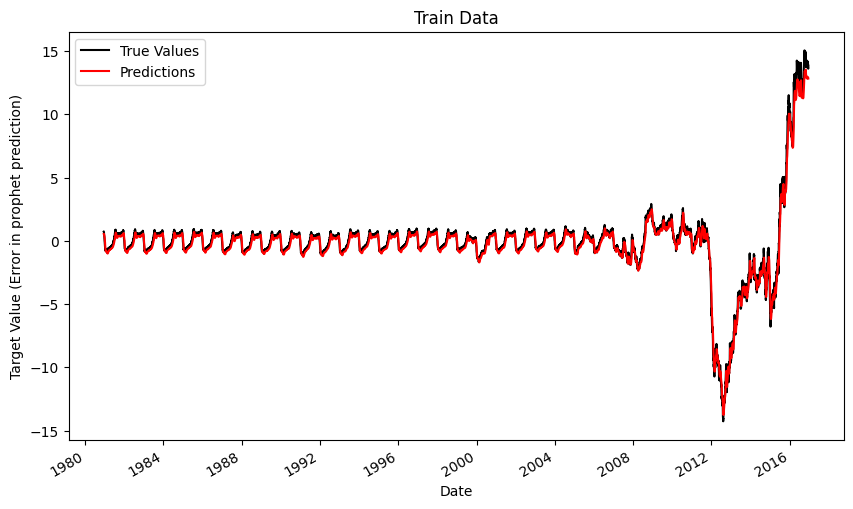

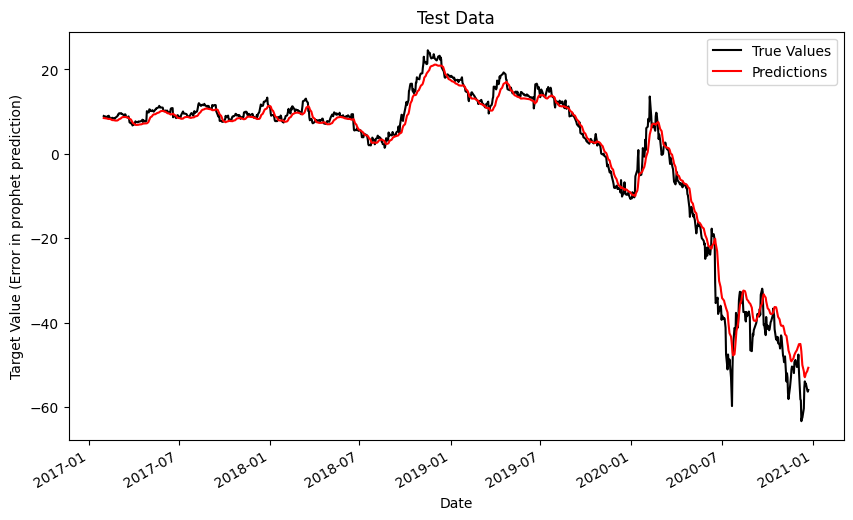

In [186]:
train_period = train_dates[0:len(train_dates) - WINDOW_SIZE]
test_period = test_dates[0:len(test_dates) - WINDOW_SIZE]

plot_predictions(train_pred, train_output, 'Train Data', train_period)
plot_predictions(test_pred, test_output, 'Test Data', test_period)

In [199]:
# predictions = []

In [200]:
# def predict_the_future(input_seq, period_prediction: int = 7):
#     if period_prediction == 0:
#         return predictions
#     new_prediction = model.predict(input_seq)
#     predictions.append(new_prediction[0][0])

#     # Properly stack old sequence (29 steps) with the new predicted step (1 step)
#     new_seq = np.array([np.vstack((input_seq[0][1:], new_prediction[0].reshape(1, 1)))])

#     return predict_the_future(new_seq, period_prediction - 1)

In [201]:
# # Reconstruct adjusted prediction: Prophet + LSTM error correction
# corrected_forecast = forecast.iloc[:-60].copy()
# corrected_forecast['corrected_price'] = corrected_forecast['yhat'].values + np.concatenate([train_pred.flatten(), test_pred.flatten()])

# plt.figure(figsize=(12, 6))
# plt.plot(corrected_forecast['ds'], corrected_forecast['yhat'], label='Prophet Prediction', color='blue')
# plt.plot(corrected_forecast['ds'], corrected_forecast['corrected_price'], label='Prophet + LSTM Correction', color='red')
# plt.plot(merged['ds'], merged['y'], label='Actual Price', color='green')
# plt.title('Prophet vs Prophet+LSTM vs Actual Price')
# plt.xlabel('Date')
# plt.ylabel('Price (USD)')
# plt.legend()
# plt.grid()
# plt.show()

In [203]:
# seq_start = LSTM_data.values[-WINDOW_SIZE:].reshape(1, WINDOW_SIZE, 1)
# # if len(seq_start[0]) != WINDOW_SIZE:
# #     raise "Size mismatch"
# future_predictions = predict_the_future(seq_start, 10)
# print(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[np.float32(0.66730064), np.float32(0.3928583), np.float32(0.37384215), np.float32(0.3465439), np.float32(0.3021337), np.float32(0.25404963), np.float32(0.21456796), np.float32(0.66730064), np.float32(0.3928583), np.float32(0.37384215), np.float32(0.3465439), np.float32(0.3021337), np.float32(0.25404963), np.float32(0.21456796), np.float32(0.1785789), np.float32(0.14261906), np.float32(0.11130774)]
